In [1]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import keras.backend.tensorflow_backend as ktf

import matplotlib.pyplot as plt

from common import *

%matplotlib inline
import visualization as viz
viz.set_plot_style()

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

Using TensorFlow backend.


numpy ver.: 1.13.1
pandas ver.: 0.19.0
tensorflow ver.: 1.0.0
keras ver.: 2.0.8


In [2]:
def get_session(gpu_fraction=1):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

## Functions

### Functions for generate data

In [19]:
def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links)))
    model.add(LSTM(name ='lstm_1',
                   units = 64,
                   return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(LSTM(name ='lstm_2',
                   units = 64,
                   return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(RepeatVector(output_timesteps))
    
    model.add(LSTM(name ='lstm_3',
                   units = 64,
                   return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(LSTM(name ='lstm_4',
                   units = num_links,
                   return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=num_links, name = 'dense_1', activation = 'linear')))

    optimizer = RMSprop()
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [9]:
def info(msg):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " " + msg)

## Load data

In [10]:
data = prep_data('../data/4A_1_201705_201710.csv')
print(len(data))

1213677


Subset the part of the 4A line that are identical across all journey patterns.

In [11]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 32)]
data = data[data['LinkTravelTime'].notnull()]
assert len(data['LinkRef'].unique()) == 32
n = len(data)
print(n)

907390


In [12]:
lags = 4 * 8
preds = 3

## Train and test

In [13]:
# Devide into test and train
data_train = data[data['DateTime'] < '2017-10-10']
data_test = data['2017-10-10' <= data['DateTime']]
n_train = len(data_train)
n_test = len(data_test)
info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 100. * n_train / n))
info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 100. * n_test / n))

2017-11-06 10:41:34 - Train size :   873720 (96.29%) 
2017-11-06 10:41:34 - Test size  :    33670 (3.71%) 


In [14]:
# Mean center and scale
(means, scales, low, upr) = fit_scale(data_train)
assert means.shape == (4 * 24 * 7, 32)
assert len(scales) == 32
assert low.shape == (4 * 24 * 7, 32)
assert upr.shape == (4 * 24 * 7, 32)

In [21]:
ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train, means, scales)
ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test, means, scales)

# Create rolling window tensor
X_train, Y_train, Y_ix_train, Y_rm_mean_train, Y_scale_train, Y_w_train = roll(ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lags, preds)
X_test, Y_test, Y_ix_test, Y_rm_mean_test, Y_scale_test, Y_w_test = roll(ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lags, preds)

X_train = X_train[:,:,:]
Y_train = Y_train[:,:,:]
X_test = X_test[:,:,:]
Y_test = Y_test[:,:,:]

info('- X_train shape : {:>20}    X_test shape : {:>20}'.format(X_train.shape, X_test.shape))
info('- Y_train shape : {:>20}    Y_test shape : {:>20}'.format(Y_train.shape, Y_test.shape))

2017-11-06 10:44:22 - X_train shape :      (15512, 32, 32)    X_test shape :        (544, 32, 32)
2017-11-06 10:44:22 - Y_train shape :       (15512, 3, 32)    Y_test shape :         (544, 3, 32)


In [22]:
global_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

model = build_model(lags, preds, len(lns_train))

# Train
history = model.fit(X_train, Y_train,
                    batch_size = 64, epochs = 30,
                    shuffle = False, validation_data = (X_test, Y_test),
                    verbose = 2, callbacks = [early_stopping])
model.save('models/PureLSTM_Comparison.h5') 

Y_true = Y_test.squeeze() * Y_scale_test + Y_rm_mean_test
Y_naive = Y_rm_mean_test
Y_pred = model.predict(X_test).squeeze() * Y_scale_test + Y_rm_mean_test

Y_true_total = np.sum(Y_true * Y_w_test, axis = 2).squeeze()
Y_naive_total = np.sum(Y_naive * Y_w_test, axis = 2).squeeze()
Y_pred_total = np.sum(Y_pred * Y_w_test, axis = 2).squeeze()
    
for t in range(preds):
    mask = Y_true_total[:,t] > 0
    Y_true_total_t = Y_true_total[mask, t] / 60
    Y_naive_total_t = Y_naive_total[mask, t] / 60
    Y_pred_total_t = Y_pred_total[mask, t] / 60  

    error_naive_total_t = (Y_naive_total_t - Y_true_total_t)
    error_lstm_total_t = (Y_pred_total_t - Y_true_total_t)

    mae_ha = np.mean(np.abs(error_naive_total_t))
    rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
    mape_ha = np.mean(np.abs(error_naive_total_t) / Y_true_total_t) * 100

    mae_lstm = np.mean(np.abs(error_lstm_total_t))
    rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
    mape_lstm = np.mean(np.abs(error_lstm_total_t) / Y_true_total_t) * 100

    info("- t + %d - HA       - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))
    info("- t + %d - PureLSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
    info("- t + %d - *        - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))


Train on 15512 samples, validate on 544 samples
Epoch 1/30
34s - loss: 2.1872 - val_loss: 2.8690
Epoch 2/30
32s - loss: 2.1548 - val_loss: 2.7408
Epoch 3/30
32s - loss: 2.1329 - val_loss: 2.7548
Epoch 4/30
32s - loss: 2.1076 - val_loss: 2.8209
Epoch 5/30
32s - loss: 2.0811 - val_loss: 2.8846
Epoch 6/30
32s - loss: 2.0575 - val_loss: 2.9010
2017-11-06 10:47:48 - t + 1 - HA       - MAE:  5.68 - RMSE:  9.28 - MAPE:  6.27
2017-11-06 10:47:48 - t + 1 - PureLSTM - MAE:  4.94 - RMSE:  7.90 - MAPE:  5.87
2017-11-06 10:47:48 - t + 1 - *        - MAE: -0.74 - RMSE: -1.38 - MAPE: -0.40
2017-11-06 10:47:48 - t + 2 - HA       - MAE:  5.64 - RMSE:  9.22 - MAPE:  6.24
2017-11-06 10:47:48 - t + 2 - PureLSTM - MAE:  5.16 - RMSE:  8.31 - MAPE:  6.12
2017-11-06 10:47:48 - t + 2 - *        - MAE: -0.48 - RMSE: -0.91 - MAPE: -0.13
2017-11-06 10:47:48 - t + 3 - HA       - MAE:  5.60 - RMSE:  9.16 - MAPE:  6.24
2017-11-06 10:47:48 - t + 3 - PureLSTM - MAE:  5.22 - RMSE:  8.43 - MAPE:  6.21
2017-11-06 10:47:4

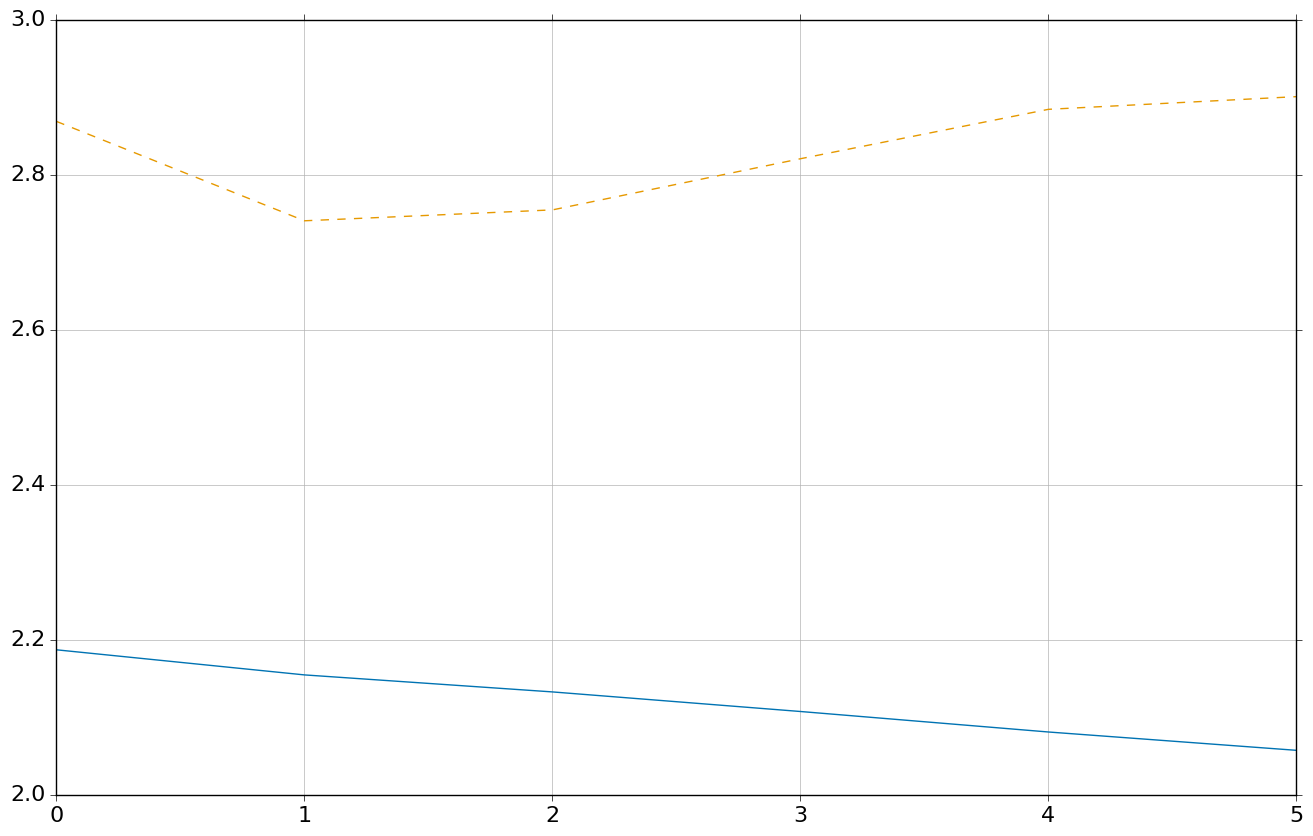

In [23]:
plt.plot(history.history['loss'], color = viz.colors['Bu'])
plt.plot(history.history['val_loss'], linestyle = '--', color = viz.colors['Or'])

In [24]:
output = pd.DataFrame(data = Y_pred[:,0,:], index = Y_ix_test, columns = lns_test)

In [25]:
output.to_csv('../data/Output-PureLSTM.csv')

In [27]:
results = pd.DataFrame(columns = ['Model', 'Time ahead', 'RMSE (min)', 'MAE (min)', 'MAPE (%)', 'SMAPE (%)'])

ix_eval = Y_ix_test[('2017-10-11' <= Y_ix_test) & (Y_ix_test <= '2017-10-14')]
ix_eval = ix_eval[ix_eval.indexer_between_time('06:00', '22:00')]
mask = Y_ix_test.isin(ix_eval)

Y_true_total_ = np.sum(Y_true[mask], axis = 2).squeeze() / 60
Y_naive_total_ = np.sum(Y_naive[mask], axis = 2).squeeze() / 60
Y_pred_total_ = np.sum(Y_pred[mask], axis = 2).squeeze() / 60

for t in range(preds):
    rmse = np.sqrt(np.mean((Y_true_total_[:,t] - Y_pred_total_[:,t])**2))
    mae = np.mean(np.abs((Y_true_total_[:,t] - Y_pred_total_[:,t])))
    mape = np.mean(np.abs((Y_true_total_[:,t] - Y_pred_total_[:,t])) / Y_true_total_[:,t]) * 100
    smape = np.mean(np.abs((Y_true_total_[:,t] - Y_pred_total_[:,t])) / (np.abs(Y_true_total_[:,t]) + np.abs(Y_pred_total_[:,t])) / 2) * 100
    results = results.append(pd.DataFrame([['PureLSTM', 't + ' + str(t+1) + ' (' + str(15+t*15) + ' min)', rmse, mae, mape, smape]], columns = results.columns), ignore_index = True)

results.set_index('Model')

,Time ahead,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,,
PureLSTM,t + 1 (15 min),3.482980,2.475227,5.023274,1.300641
PureLSTM,t + 2 (30 min),3.555931,2.506649,5.076020,1.314723
PureLSTM,t + 3 (45 min),3.684890,2.622132,5.335662,1.380861


In [32]:
print(results[['Model', 'Time ahead', 'RMSE (min)', 'MAE (min)', 'MAPE (%)']].to_latex(index = False))

\begin{tabular}{llrrr}
\toprule
    Model &      Time ahead &  RMSE (min) &  MAE (min) &  MAPE (\%) \\
\midrule
 PureLSTM &  t + 1 (15 min) &    3.482980 &   2.475227 &  5.023274 \\
 PureLSTM &  t + 2 (30 min) &    3.555931 &   2.506649 &  5.076020 \\
 PureLSTM &  t + 3 (45 min) &    3.684890 &   2.622132 &  5.335662 \\
\bottomrule
\end{tabular}

